In [1]:
experiment_setup_name = "musicians_category_example_small_net_single_sample_batch_rmsprop_second_chance"

In [2]:
import sys
sys.path.append("..")

In [3]:
#import everything in the world
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2
import pandas as pd
!mkdir ~/agentnet_snapshots


Couldn't import dot_parser, loading of dot files will not be possible.
mkdir: cannot create directory '/root/agentnet_snapshots': File exists


In [4]:
floatX = theano.config.floatX

from auxilary import _shared,set_shared,_in1d
from persistence import save,load


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* 1000 нейронов
* с epsilon-greedy обучением
* Тупой SGD с Nesterov Mommentum


Много вспомогательного кода

# Постановка задачи
* В начале сетке даётся некоторый человек, про которого она пока ничего не знает
* Человек - музыкант или околомузыкальная личность (с меньшей вероятностью - группа или... страна)
* Про человека известен некоторый набор фактов
 * факты типа "Известно, что" - за то, что какой-то аттрибут есть в его вики-карточке
   * например Nickname:is_known - есть прозвище, Died:is_known - есть дата смерти
 * Категориальные факты
   * инструменты, на которых играет человек
   * происхождение
   * декады активности
   * и т.п.


* За один шаг сетка может
 * сказать, что какой-то аттрибут про пользователя есть
   * например, Nickname:is_known - предположение, что у пользователя есть прозвище
   * если догадка верна, сеть получает положительное подкрепление ("конфетку")
   * если нет - отрицательное ("подзатыльник")
 * сказать "больше ничего не угадаю, несите следующего"
   * нулевое подкрепление
   * случайно выбирается следующий пользователь
  

# данные
* Всего в выборке 434 аттрибута
 * примеры аттрибутов в табе ниже
* В данном случае сеть обучается на чуть менее, чем 2500 случайных людей
* всего в выборке почти 100к людей/групп/всякого трэша

In [5]:
#вгрузим данные про кучу музыкантов 
#как оно собирается - ./data/preprocessing.ipynb
import pandas as pd
df = pd.DataFrame.from_csv("../data/musicians_categorized.csv")

0.0346481118134
(22612, 393)


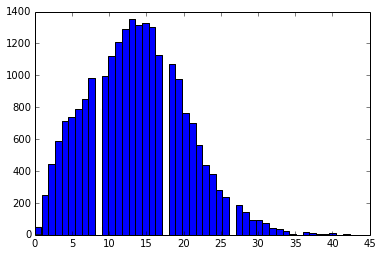

In [6]:
#гистограмма количества аттрибутов известных про музыканта
plt.hist((df.values).sum(axis=1),bins=50)
print (df.values).mean()
print df.shape

In [7]:
#отрежем тех, про кого известно менее 5 аттрибутов
df =  df[df.values.sum(axis=1) > 15]
print "всего самплов", df.shape

всего самплов (8594, 393)


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
#split categories and attributes
feature_names = df.columns
categorical_columns = np.nonzero(map(lambda s: s.startswith("category:"),feature_names))[0]
attribute_columns = np.nonzero(map(lambda s: not s.startswith("category:"),feature_names))[0]

data_cats = df.iloc[:,categorical_columns]
data_attrs = df.iloc[:,attribute_columns]



In [10]:
#поделим выборку
train_cats,test_cats,train_attrs,test_attrs = train_test_split(data_cats,data_attrs,test_size=0.99,random_state=42)
print "обучающая выборка:" ,len(train_attrs)
print "контрольная выборка:", len(test_attrs)

обучающая выборка: 85
контрольная выборка: 8509


# problem definition

Обучатор состоит из 2 частей
* "среды обучения"
* определятора полезностей
* самой нейронки

Среда обучения - такая штука, которая 
* подсовывает нейронке людей, 
 * каждый раз выбирается случайное подмножество людей 
   * (можно и 100 и 10 - просто не успел сравнить)
   * возвращает ответы на действия нейронки, попутно обновляя своё состояние
Определятор полезностей
* умеет считать полезность каждого действия по паре "состояние СРЕДЫ, действие агента ИЗ этого состояния"
* имеет функции для быстрого определения наград за все действия в сессиях

Нейронка будет далее по списку


__***для простоты, CategoryGuess будет имплементировать И среду И награждатор (см. класс ниже)***__

In [11]:
from objective import BaseObjective
from environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = _shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  _shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = _shared("batch_size_scalar",batch_size,'int32')
        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1).astype('float32')
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        attrs_batch = np.array(attrs_batch)
        categories_batch = np.array(categories_batch)
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)
        set_shared(self._batch_size,attrs_batch.shape[0])

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+1).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())
    

    
    def get_first_state(self,batch_size=1):
        assert batch_size == self._joint_data.shape[0].eval()
        return T.zeros_like(self._joint_data,dtype='uint8') 
    
    
    def get_output_and_observation(self,last_state,action):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation

    def get_reward(self,batch_i,session_states,session_actions):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[batch_id, memory_id]: environment state before taking action
            session_actions int[batch_id]: agent action at this tick
        returns:
            reward float[batch_id]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _action_is_categorical = _in1d(session_actions, self._category_action_ids)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
        
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*4-2,
            _response*2-1
        )
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            0,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [12]:
env = CategoryGuess(train_attrs.shape[1],train_cats.shape[1],5)

# agent setup
В свою очередь, нейронка состоит из 3 частей
* память агента
    * на вход получает пару (предыдущее состояние памятиа агента, сенсорная инфа о среде на ЭТОМ шагу)
    * определяет текущее состояние памяти агента (на том же шагу, что и сенсорная инф-ция со входа)
    * тут - GRUlayer, в потенциале - вообще что угодно, хоть 10 шагов LSTM за 1 раз
       * какой именно GRUlayer:
       * Reset gate - dense w/ expit
       * Update gate - dense w/ expit
       * Hidden update gate - dense w/ tanh

* определятор Q-значений
    * на вход получает память агента
    * определяет Q_значения каждого действия
    * тут - DenseLayer, потенциал - что угодно
* приниматор решений по Q-значениям
    * на вход получает Q-значения для действий
    * определяет, как вывод нейронки трансформируется в решение,
    * формат выхода - целые числа - номера выбранных действий
     * тут - с вероятностью epsilon берётся решение, 
       * которому предсказана наибольшая полезность
       * иначе берётся случайное равновероятное
     * альтернативный вариант - решения выбираются с веростностями
       * $Pi(a) = softmax(Qi(a)) = {e^{Qi(x)}} / {\sum\limits_{j=1}^n e^{Qj(X)}}$ 
       * где Q(a) - предсказанная полезность действия a
* всё это делается векторизованно для батча произвольной размерности


### Agent - просто обёртка над этими 3 пунктами
* строго говоря, можно воткнуть любую нейронку, которая мапает 
* `float last_agent_state[batch,units], float observation[batch,sensors] ->`
* `-> float new_agent_state[batch,units], float qvalues[batch,actions], int actions[batch]`


In [13]:
from resolver import EpsilonGreedyResolver
from memory import GRUMemoryLayer
from agent import Agent

In [14]:
import lasagne

n_hid=100


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")
#memory
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = _shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [15]:
history = agent.get_sessions(env,session_length=20,
                       batch_size=env._joint_data.shape[0],
                       initial_env_state=env.get_first_state(env.batch_size))
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [16]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# weights
* вот так нахаляву можно вытащить ВСЕ веса нейронок агента
* что НЕ вытаскивается 
 * архитектура сети
 * гиперпараметры (жадность, gamma)
 * состояния среды/наблюдения
* короче, вытаскиваются только "нейронячие" параметры
* хочешь, чтобы в твоём слое вытащилась какая-то shared переменная - добавь её в параметры слоя [с каким-ть тэгом, если хочешь]
* всё как в ванильной лазанье

In [17]:
#all trainable weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

In [18]:
#all weights but for Qvalues prediciton ones (not to penalize q-predictors by l2)
weights_inner = filter(lambda w: "QEvaluator" not in w.name,weights)
weights_inner

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update]

# целевая функция для обучения сети

* Интуитивно, цель - предсказывать Q-значения (полезности) действий
* $Q(s,a) = R(s,a) + gamma* Max_{a'}{ Q(s',a')}  $
 * R(s,a) - непосредственная награда за действие (+5 если угадал, -1 если нет и т.п.)
 * s' - состояние, в которое агент попал, сделав действие a из состояния s
 * a' - действие, которое можно совершить в состоянии s'
 * gamma - во сколько раз награда/пинок через 1 шаг менее значимы, чем сейчас
 * интуиция - "в состоянии s полезность действия a - это непосредственная печенька за это действие ПЛЮС все печеньки, которые можно собрать, если после этого действия вести себя оптимально"
 
* В реальном мире оптимизируются попарно 2 приближения этой функции
* $ RMSE_{reccurent}: (NN_s(a) - (R + gamma* Max_a'{ NN_s'(a')})^2$
 * NN_s(a) предсказаннная из состояния s полезност Q(s,a)
 * считается для тех NN_s(a), которые агент совершил
 * NN_s'(a') - полезности всех действий сразу после совершения a из состяния s

* $ RMSE_{naive}: (NN_s(a^*) - (R + gamma*  NN_s'(a'^*))^2$
 * аналогично предыдущему, но a* - реально совершённое агентом действие
 * оценка смещена, но куда проще оптимизируется, чем предыдущая
   * по крайней мере, с softmax принятием решений

In [19]:
is_alive_seq = T.eq(state_seq[:,:,-1],0)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = _shared('q_learning_gamma',np.float32(0.95),floatX)


ref_tuples = env.get_reference_tuples(qvalues_seq,action_seq,rewards_seq,is_alive_seq,gamma_or_gammas=gamma,)

action_ids_ravel,immediate_rewards_ravel, predicted_Qvalues_ravel,reference_Qvalues_ravel,is_end_ravel= ref_tuples

from auxilary import consider_constant
reference_Qvalues_ravel = consider_constant(reference_Qvalues_ravel)

predicted_Qvalues_for_actions_ravel = predicted_Qvalues_ravel[T.arange(action_ids_ravel.shape[0]),action_ids_ravel]


In [20]:
loss_recurrent = lasagne.objectives.squared_error(reference_Qvalues_ravel,predicted_Qvalues_for_actions_ravel).mean()

In [21]:
weight_ravel = T.concatenate([w.ravel() for w in weights_inner])
reg_l2 = reg_l2 = T.mean(weight_ravel**2)*0.1


In [22]:
loss = loss_recurrent + reg_l2

# алгоритм обучения
* обучаются все параметры обычным Stochastic Gradient Descent с Nestrov Mommentum
* регуляризации нет, ибо пока не понадобилась

In [23]:
_updates = lasagne.updates.rmsprop(loss,
                                             weights,learning_rate=0.05,)
#updates = lasagne.updates.sgd(loss_recurrent,weights,0.1)

In [24]:
mean_session_reward = immediate_rewards_ravel.sum()/ rewards_seq.shape[0]
train_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward],updates=_updates)
loss_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward])

# evaluation
* удобная [мне одному] функция, которая показывает примеры сессий и внутреннее состояние нейронки
* текстовая часть - 
    * #(номер_действия) (имя_действия) (предсказанное_Qvalue) -> (награда) | следующая итерация
* картинка (если display = True)
    * X - моменты времени, Y - попугаи
    * жЫрные линии - Q-значения категорий
    * тонкие линии - Q-значения узнавания аттрибутов
    * точки на линиях - выбранные действия
    * пунктирные линии - активация нейронов в памяти агента
    * синяя черта (тонкая, вертикальная) - конец сессии (действие или лимит времени)


In [25]:
evaluation_fun = theano.function([],[action_ids_ravel,predicted_Qvalues_for_actions_ravel,immediate_rewards_ravel,
                                     reference_Qvalues_ravel,is_end_ravel,
                                     hidden_seq,qvalues_seq,action_seq])


In [26]:
#new names order
feature_names = list(data_attrs.columns) + list(data_cats.columns) + ["<end_session_action>"]
is_categorical = lambda i: feature_names[i].startswith("category:")

def print_session(n_sessions = 3,display=False,legend=True):
    
    a_lot_of_data = evaluation_fun()    
    actions,qvalues,rewards,ref_qvalues,end_sel = a_lot_of_data[:5]
    hidden_log,qvalues_log,action_log = a_lot_of_data[5:]
    
    
    
    b_i = 0 #batch iter ~ session iter
    t_i = 0 #time iter
    

    for a,q,r,q_ref,is_end in zip(actions,qvalues,rewards,ref_qvalues,end_sel):
        print "#%i: %s (%.3f) -> %s |"%(a,feature_names[a],q, r,),
        
        
        t_i +=1
        if is_end ==1:
            
            print '<end>'
            print 'true:',
            for cat in env._categories.get_value()[b_i].nonzero()[0]:
                print feature_names[cat+env._attributes.shape[1].eval()],
            print
                
            #plot qvalues
            if display:
                plt.figure(figsize=[16,8])

                q_values = qvalues_log[b_i].T
                for i in range(q_values.shape[0]):
                    plt.plot(q_values[i],label=feature_names[i],linewidth = 1 + 4*is_categorical(i))

                hidden_activity =  hidden_log[b_i].T
                for i, hh in enumerate(hidden_activity):
                    plt.plot(hh,'--',label='n'+str(i))
                    
                session_actions = action_log[b_i,:t_i]
                action_range = np.arange(len(session_actions))
                plt.scatter(action_range, qvalues_log[b_i][action_range, session_actions])


                #session end
                plt.plot(np.repeat(t_i-1,2),np.linspace(-0.5,0.5,2))
                plt.xlim(0,max(t_i*1.1,2))
                plt.xticks(np.arange(t_i))
                plt.grid()
                if legend:
                    plt.legend()
                plt.show()
                
            print
            #/
            b_i +=1
            t_i = 0

            if b_i >= n_sessions:
                break


# training

In [27]:
def load_random_batch(env,attrs,cats,batch_size=10):
    
    attrs,cats = np.array(attrs),np.array(cats)
    
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

In [28]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
alpha = 0.1
ma_reward = 0.
ma_reward_greedy = 0.

# само обучение
* шаг алгоритма - 
 * выбрать B случайных людей
 * пересчитать "жадность" алгоритма (чем дальше, тем более жадный)
 * сделать шаг обучения
 * раз в M итераций - добавить точку на график обучения по 3 метрикам
   * ожидание награды за сессию при текущей жадности на тренировочных данных
   * то же самое при максимальной жадности
 * раз в N итераций - 
   * показать несколько примеров сессий на обучающих данных при разной жадности
   * показать графики обучения
 * раз в K итераций - записать веса нейронки в файл (snapshot)

epoch 100,loss 517.81732, greed 0.20180, rewards: ( train -20.43152, det_train 0.00000) 
rec 517.814 reg 0.004
epoch 200,loss 1144.10901, greed 0.20359, rewards: ( train -17.70361, det_train -0.20000) 
rec 1144.103 reg 0.006
epoch 300,loss 748.88501, greed 0.20538, rewards: ( train -18.29030, det_train -0.28000) 
rec 748.877 reg 0.008
epoch 400,loss 1321.67224, greed 0.20717, rewards: ( train -18.24835, det_train -0.05200) 
rec 1321.662 reg 0.010
epoch 500,loss 1609.01001, greed 0.20896, rewards: ( train -19.14545, det_train -0.14680) 
rec 1609.000 reg 0.010
epoch 600,loss 1904.57678, greed 0.21074, rewards: ( train -18.01177, det_train -0.23212) 
rec 1904.566 reg 0.010
epoch 700,loss 1783.86719, greed 0.21251, rewards: ( train -18.06396, det_train -0.30891) 
rec 1783.856 reg 0.011
epoch 800,loss 2268.11743, greed 0.21429, rewards: ( train -20.67968, det_train -0.17802) 
rec 2268.106 reg 0.011
epoch 900,loss 2693.27759, greed 0.21606, rewards: ( train -17.27908, det_train -0.46022) 
re

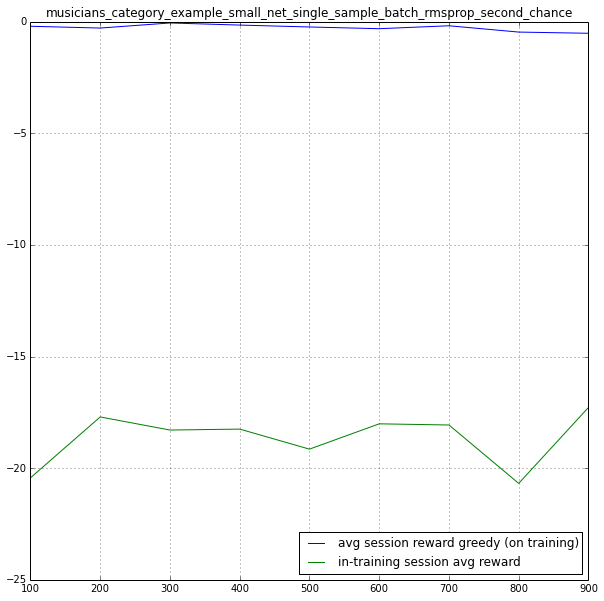

epoch 1000,loss 2425.65039, greed 0.21782, rewards: ( train -18.50391, det_train -0.51419) 
rec 2425.639 reg 0.012
epoch 1100,loss 2611.58643, greed 0.21958, rewards: ( train -17.25332, det_train -0.66277) 
rec 2611.574 reg 0.012
epoch 1200,loss 103.12272, greed 0.22134, rewards: ( train -15.73883, det_train -0.89650) 
rec 103.110 reg 0.012
epoch 1300,loss 2997.56860, greed 0.22310, rewards: ( train -17.44626, det_train -1.10685) 
rec 2997.556 reg 0.013
epoch 1400,loss 3431.89502, greed 0.22485, rewards: ( train -18.53457, det_train -1.09616) 
rec 3431.882 reg 0.013
epoch 1500,loss 3173.55981, greed 0.22660, rewards: ( train -16.96130, det_train -1.08655) 
rec 3173.547 reg 0.013
epoch 1600,loss 3495.95923, greed 0.22834, rewards: ( train -18.05253, det_train -1.07789) 
rec 3495.946 reg 0.013
epoch 1700,loss 3581.50366, greed 0.23009, rewards: ( train -16.34228, det_train -1.27010) 
rec 3581.490 reg 0.014
epoch 1800,loss 3787.76318, greed 0.23182, rewards: ( train -17.34698, det_train -

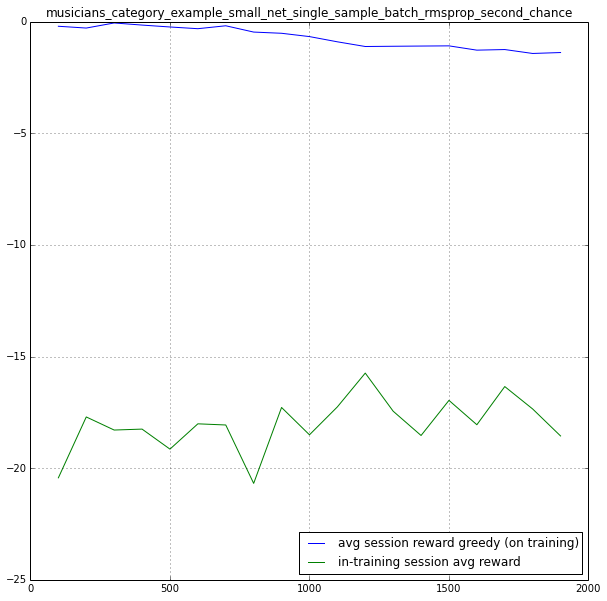

epoch 2000,loss 2700.76587, greed 0.23529, rewards: ( train -19.85800, det_train -1.37690) 
rec 2700.753 reg 0.012
epoch 2100,loss 2082.89062, greed 0.23702, rewards: ( train -17.14662, det_train -1.33921) 
rec 2082.878 reg 0.012
epoch 2200,loss 2145.69482, greed 0.23874, rewards: ( train -17.01152, det_train -1.40529) 
rec 2145.683 reg 0.012
epoch 2300,loss 2268.47754, greed 0.24046, rewards: ( train -18.17765, det_train -1.56476) 
rec 2268.465 reg 0.012
epoch 2400,loss 1143.18872, greed 0.24218, rewards: ( train -17.77741, det_train -1.60829) 
rec 1143.176 reg 0.013
epoch 2500,loss 939.02979, greed 0.24389, rewards: ( train -16.75476, det_train -1.64746) 
rec 939.019 reg 0.011
epoch 2600,loss 1525.83569, greed 0.24560, rewards: ( train -17.49981, det_train -1.58271) 
rec 1525.824 reg 0.011
epoch 2700,loss 702.85687, greed 0.24731, rewards: ( train -19.24432, det_train -1.82444) 
rec 702.845 reg 0.012
epoch 2800,loss 65.25378, greed 0.24901, rewards: ( train -17.61082, det_train -1.74

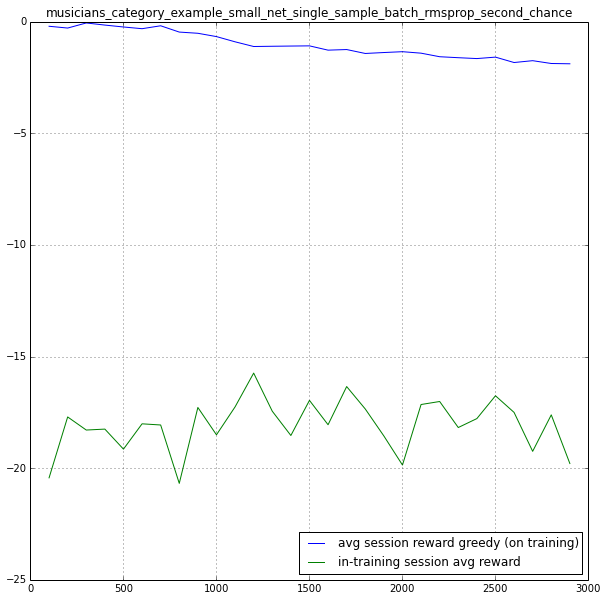

epoch 3000,loss 525.79303, greed 0.25241, rewards: ( train -18.03788, det_train -1.88102) 
rec 525.779 reg 0.014
epoch 3100,loss 1105.34155, greed 0.25411, rewards: ( train -18.94090, det_train -2.09292) 
rec 1105.326 reg 0.016
epoch 3200,loss 901.65881, greed 0.25580, rewards: ( train -16.92203, det_train -1.98362) 
rec 901.642 reg 0.017
epoch 3300,loss 946.27643, greed 0.25748, rewards: ( train -16.63148, det_train -2.08526) 
rec 946.259 reg 0.018
epoch 3400,loss 1600.86365, greed 0.25917, rewards: ( train -17.89220, det_train -1.87674) 
rec 1600.845 reg 0.019
epoch 3500,loss 1380.93750, greed 0.26085, rewards: ( train -17.13535, det_train -1.98906) 
rec 1380.918 reg 0.020
epoch 3600,loss 1315.84509, greed 0.26252, rewards: ( train -18.95770, det_train -2.19016) 
rec 1315.824 reg 0.021
epoch 3700,loss 1137.62842, greed 0.26420, rewards: ( train -17.62100, det_train -2.07114) 
rec 1137.607 reg 0.022
epoch 3800,loss 814.31836, greed 0.26587, rewards: ( train -18.38674, det_train -2.264

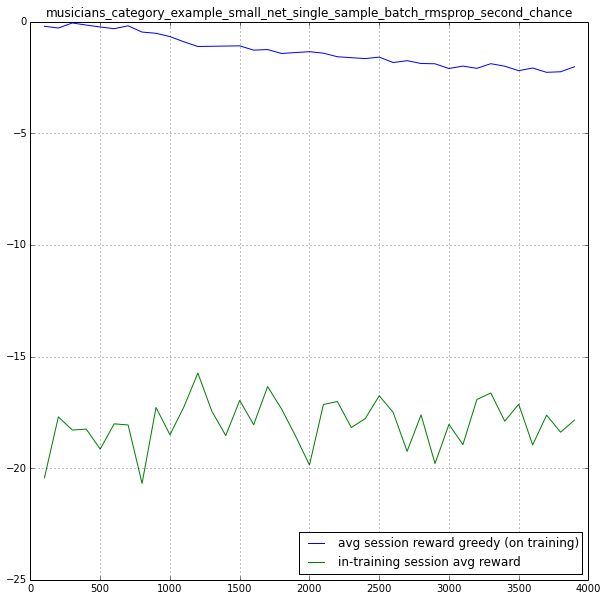

epoch 4000,loss 841.36615, greed 0.26920, rewards: ( train -16.97290, det_train -2.01386) 
rec 841.342 reg 0.024
epoch 4100,loss 980.17688, greed 0.27086, rewards: ( train -17.87976, det_train -1.91248) 
rec 980.153 reg 0.024
epoch 4200,loss 1059.97290, greed 0.27251, rewards: ( train -18.60956, det_train -1.92123) 
rec 1059.948 reg 0.025
epoch 4300,loss 1045.92773, greed 0.27417, rewards: ( train -15.69920, det_train -2.02910) 
rec 1045.902 reg 0.026
epoch 4400,loss 117.17474, greed 0.27582, rewards: ( train -17.29847, det_train -2.02619) 
rec 117.148 reg 0.026
epoch 4500,loss 922.82776, greed 0.27746, rewards: ( train -16.23752, det_train -2.22357) 
rec 922.800 reg 0.027
epoch 4600,loss 817.61804, greed 0.27911, rewards: ( train -16.45111, det_train -2.30122) 
rec 817.590 reg 0.028
epoch 4700,loss 683.31439, greed 0.28075, rewards: ( train -17.77483, det_train -2.27110) 
rec 683.286 reg 0.029
epoch 4800,loss 636.31335, greed 0.28238, rewards: ( train -18.00947, det_train -2.04399) 
r

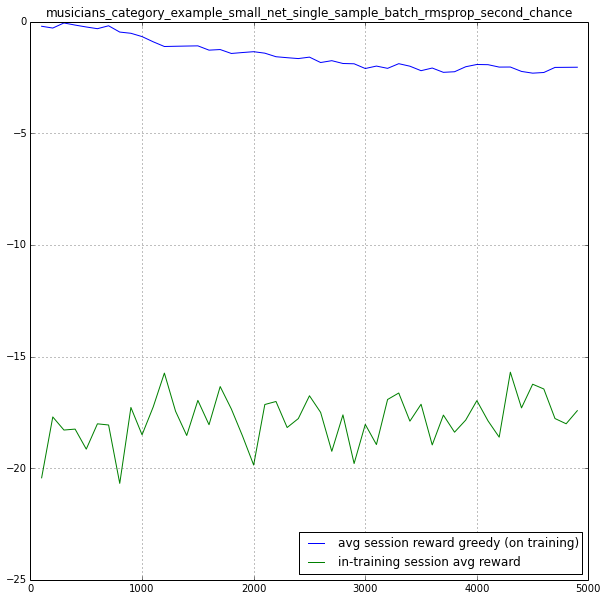

snapshot saved
epoch 5000,loss 80.04803, greed 0.28565, rewards: ( train -18.22669, det_train -2.03563) 
rec 80.018 reg 0.030
epoch 5100,loss 810.74384, greed 0.28727, rewards: ( train -18.05659, det_train -2.03207) 
rec 810.713 reg 0.031
epoch 5200,loss 1205.65820, greed 0.28890, rewards: ( train -18.02612, det_train -2.12886) 
rec 1205.626 reg 0.032
epoch 5300,loss 611.62006, greed 0.29052, rewards: ( train -18.07783, det_train -2.21597) 
rec 611.588 reg 0.032
epoch 5400,loss 786.50476, greed 0.29214, rewards: ( train -17.44542, det_train -2.19438) 
rec 786.472 reg 0.033
epoch 5500,loss 34.95562, greed 0.29375, rewards: ( train -17.02299, det_train -2.27494) 
rec 34.922 reg 0.033
epoch 5600,loss 687.16473, greed 0.29536, rewards: ( train -17.50337, det_train -2.54744) 
rec 687.131 reg 0.034
epoch 5700,loss 595.56445, greed 0.29697, rewards: ( train -16.25948, det_train -2.59270) 
rec 595.530 reg 0.034
epoch 5800,loss 41.10903, greed 0.29857, rewards: ( train -14.70992, det_train -2.2

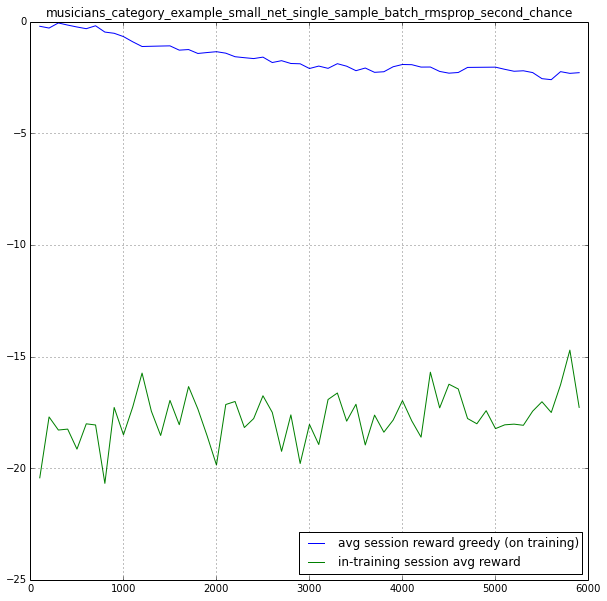

epoch 6000,loss 630.25293, greed 0.30177, rewards: ( train -17.63767, det_train -2.27908) 
rec 630.219 reg 0.034
epoch 6100,loss 380.05530, greed 0.30337, rewards: ( train -17.29500, det_train -2.35117) 
rec 380.021 reg 0.034
epoch 6200,loss 949.65253, greed 0.30496, rewards: ( train -17.18388, det_train -2.41605) 
rec 949.618 reg 0.035
epoch 6300,loss 872.67700, greed 0.30655, rewards: ( train -18.58360, det_train -2.47445) 
rec 872.642 reg 0.035
epoch 6400,loss 960.42542, greed 0.30813, rewards: ( train -16.53662, det_train -2.42700) 
rec 960.390 reg 0.035
epoch 6500,loss 1214.61780, greed 0.30971, rewards: ( train -17.05702, det_train -2.48430) 
rec 1214.582 reg 0.036
epoch 6600,loss 646.09314, greed 0.31129, rewards: ( train -15.81807, det_train -2.63587) 
rec 646.057 reg 0.036
epoch 6700,loss 879.45331, greed 0.31287, rewards: ( train -16.89637, det_train -3.37229) 
rec 879.418 reg 0.036
epoch 6800,loss 761.92346, greed 0.31444, rewards: ( train -17.21585, det_train -3.43506) 
rec

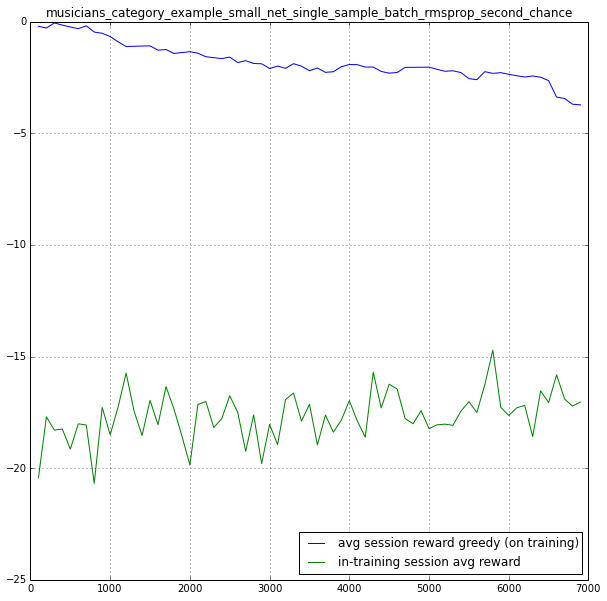

epoch 7000,loss 840.43665, greed 0.31758, rewards: ( train -16.03619, det_train -3.72240) 
rec 840.401 reg 0.035
epoch 7100,loss 679.76605, greed 0.31914, rewards: ( train -14.99181, det_train -3.85016) 
rec 679.731 reg 0.035
epoch 7200,loss 880.71899, greed 0.32070, rewards: ( train -15.02014, det_train -3.86514) 
rec 880.684 reg 0.035
epoch 7300,loss 297.17120, greed 0.32226, rewards: ( train -16.25155, det_train -3.97863) 
rec 297.136 reg 0.035
epoch 7400,loss 88.18364, greed 0.32381, rewards: ( train -16.41338, det_train -3.88076) 
rec 88.148 reg 0.036
epoch 7500,loss 69.43929, greed 0.32536, rewards: ( train -14.92569, det_train -3.79269) 
rec 69.404 reg 0.036
epoch 7600,loss 618.71716, greed 0.32691, rewards: ( train -16.51707, det_train -3.41342) 
rec 618.681 reg 0.036
epoch 7700,loss 393.22540, greed 0.32846, rewards: ( train -16.73330, det_train -3.17208) 
rec 393.189 reg 0.036
epoch 7800,loss 485.91458, greed 0.33000, rewards: ( train -16.52627, det_train -2.95487) 
rec 485.8

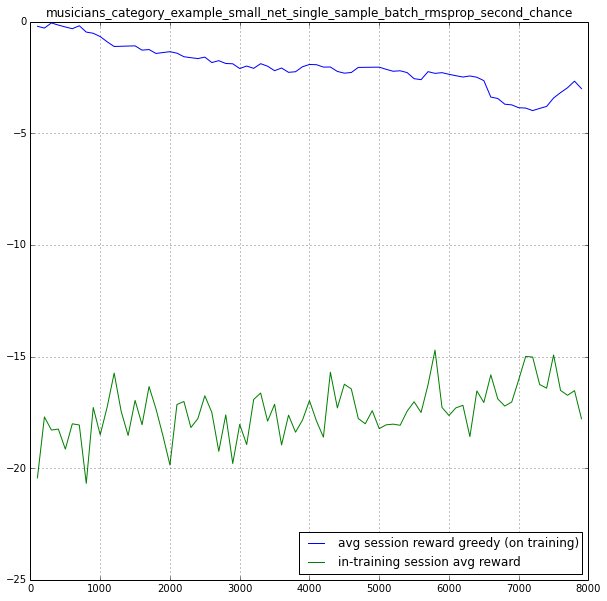

epoch 8000,loss 31.99536, greed 0.33307, rewards: ( train -15.09682, det_train -2.99344) 
rec 31.959 reg 0.036
epoch 8100,loss 623.13525, greed 0.33460, rewards: ( train -15.98195, det_train -2.99410) 
rec 623.099 reg 0.036
epoch 8200,loss 21.99604, greed 0.33613, rewards: ( train -17.30854, det_train -3.09469) 
rec 21.959 reg 0.037
epoch 8300,loss 604.20276, greed 0.33766, rewards: ( train -17.86803, det_train -3.28522) 
rec 604.166 reg 0.037
epoch 8400,loss 543.19684, greed 0.33918, rewards: ( train -17.33536, det_train -3.55670) 
rec 543.160 reg 0.037
epoch 8500,loss 585.36884, greed 0.34070, rewards: ( train -15.11210, det_train -3.50103) 
rec 585.332 reg 0.037
epoch 8600,loss 340.81564, greed 0.34222, rewards: ( train -15.43631, det_train -3.35093) 
rec 340.779 reg 0.037
epoch 8700,loss 420.37527, greed 0.34373, rewards: ( train -14.42029, det_train -3.21583) 
rec 420.339 reg 0.037
epoch 8800,loss 446.70700, greed 0.34524, rewards: ( train -14.69083, det_train -3.19425) 
rec 446.6

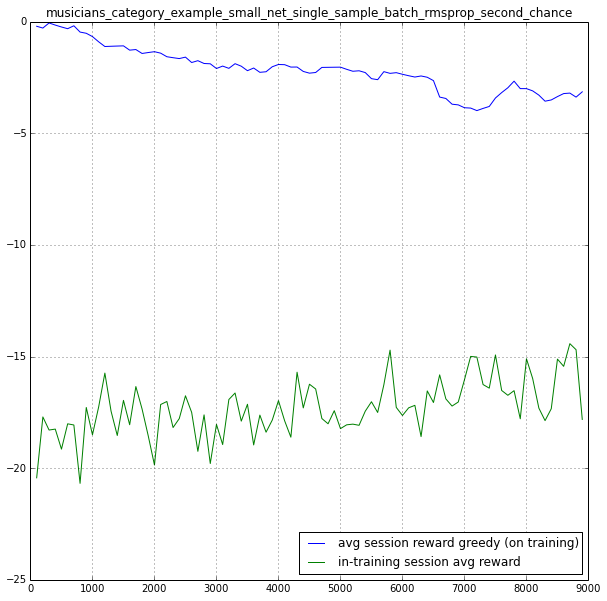

epoch 9000,loss 401.52783, greed 0.34826, rewards: ( train -18.36341, det_train -3.13734) 
rec 401.491 reg 0.037
epoch 9100,loss 227.86896, greed 0.34976, rewards: ( train -17.50040, det_train -3.22361) 
rec 227.832 reg 0.037
epoch 9200,loss 374.18768, greed 0.35126, rewards: ( train -16.55410, det_train -3.30125) 
rec 374.151 reg 0.037
epoch 9300,loss 284.71121, greed 0.35275, rewards: ( train -15.85774, det_train -3.17112) 
rec 284.675 reg 0.037
epoch 9400,loss 374.86319, greed 0.35425, rewards: ( train -17.51099, det_train -3.25401) 
rec 374.827 reg 0.037
epoch 9500,loss 261.18784, greed 0.35574, rewards: ( train -16.90453, det_train -3.42861) 
rec 261.151 reg 0.036
epoch 9600,loss 551.96814, greed 0.35722, rewards: ( train -15.98878, det_train -3.28575) 
rec 551.932 reg 0.036
epoch 9700,loss 343.80695, greed 0.35871, rewards: ( train -16.19920, det_train -3.15717) 
rec 343.771 reg 0.036
epoch 9800,loss 214.46480, greed 0.36019, rewards: ( train -16.59375, det_train -2.84146) 
rec 2

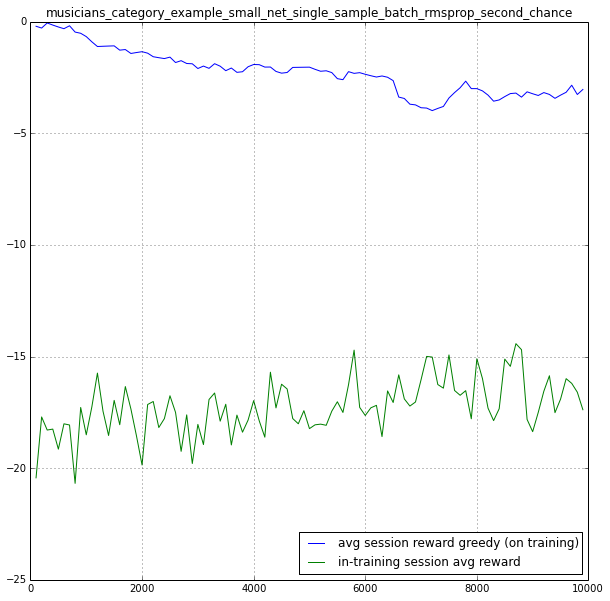

snapshot saved
epoch 10000,loss 223.56947, greed 0.36314, rewards: ( train -17.58709, det_train -3.03158) 
rec 223.533 reg 0.036
epoch 10100,loss 153.66608, greed 0.36461, rewards: ( train -16.09104, det_train -3.22842) 
rec 153.630 reg 0.036
epoch 10200,loss 211.50082, greed 0.36608, rewards: ( train -17.29926, det_train -3.30558) 
rec 211.465 reg 0.036
epoch 10300,loss 282.28372, greed 0.36755, rewards: ( train -15.49611, det_train -3.27502) 
rec 282.248 reg 0.036
epoch 10400,loss 79.59361, greed 0.36901, rewards: ( train -15.09039, det_train -3.24752) 
rec 79.558 reg 0.035
epoch 10500,loss 278.15805, greed 0.37047, rewards: ( train -17.16276, det_train -3.32277) 
rec 278.123 reg 0.035
epoch 10600,loss 243.98442, greed 0.37193, rewards: ( train -16.61053, det_train -3.19049) 
rec 243.949 reg 0.035
epoch 10700,loss 307.78278, greed 0.37339, rewards: ( train -16.26486, det_train -3.97144) 
rec 307.748 reg 0.035
epoch 10800,loss 232.94025, greed 0.37484, rewards: ( train -17.25619, det_

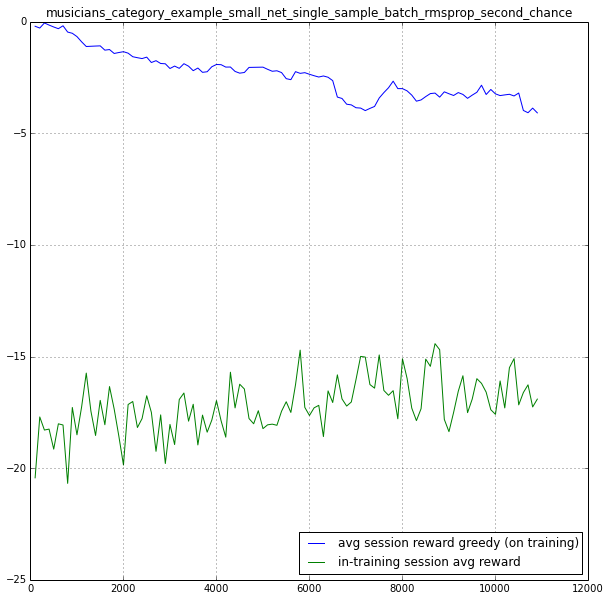

epoch 11000,loss 295.40186, greed 0.37773, rewards: ( train -16.46289, det_train -4.08018) 
rec 295.368 reg 0.034
epoch 11100,loss 160.18936, greed 0.37918, rewards: ( train -16.38822, det_train -4.17216) 
rec 160.155 reg 0.034
epoch 11200,loss 558.90918, greed 0.38062, rewards: ( train -17.50432, det_train -3.95495) 
rec 558.875 reg 0.034
epoch 11300,loss 201.11101, greed 0.38205, rewards: ( train -15.86885, det_train -3.75945) 
rec 201.077 reg 0.034
epoch 11400,loss 163.98592, greed 0.38349, rewards: ( train -18.23265, det_train -3.58351) 
rec 163.952 reg 0.034
epoch 11500,loss 132.76759, greed 0.38492, rewards: ( train -17.02139, det_train -3.52516) 
rec 132.734 reg 0.034
epoch 11600,loss 198.90991, greed 0.38635, rewards: ( train -15.99345, det_train -3.47264) 
rec 198.877 reg 0.033
epoch 11700,loss 130.74028, greed 0.38777, rewards: ( train -15.34940, det_train -3.32538) 
rec 130.707 reg 0.033
epoch 11800,loss 165.07722, greed 0.38920, rewards: ( train -15.69927, det_train -3.0928

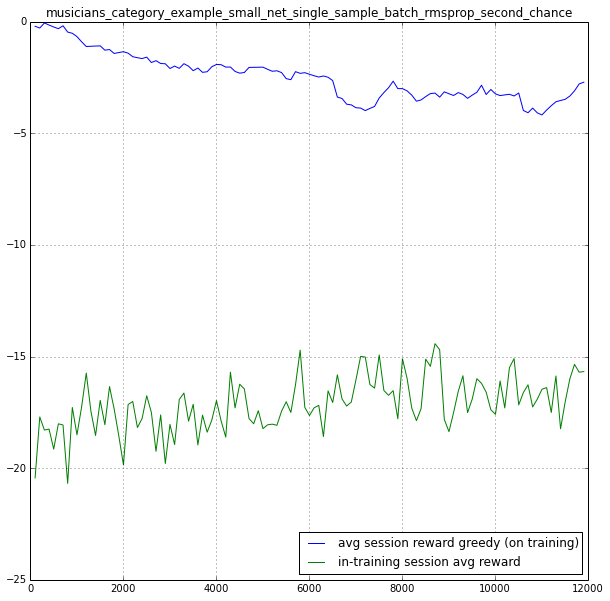

epoch 12000,loss 166.68256, greed 0.39203, rewards: ( train -16.79871, det_train -2.70520) 
rec 166.650 reg 0.032
epoch 12100,loss 104.66164, greed 0.39345, rewards: ( train -15.88403, det_train -2.73468) 
rec 104.629 reg 0.032
epoch 12200,loss 72.68910, greed 0.39486, rewards: ( train -15.19540, det_train -2.66121) 
rec 72.657 reg 0.032
epoch 12300,loss 114.09472, greed 0.39627, rewards: ( train -14.61968, det_train -2.79509) 
rec 114.063 reg 0.032
epoch 12400,loss 219.43512, greed 0.39768, rewards: ( train -15.37492, det_train -2.81558) 
rec 219.403 reg 0.032
epoch 12500,loss 98.01436, greed 0.39908, rewards: ( train -14.73677, det_train -2.43402) 
rec 97.983 reg 0.032
epoch 12600,loss 72.10001, greed 0.40048, rewards: ( train -15.98188, det_train -2.19062) 
rec 72.068 reg 0.032
epoch 12700,loss 90.97186, greed 0.40188, rewards: ( train -16.46426, det_train -1.97156) 
rec 90.940 reg 0.032
epoch 12800,loss 112.69913, greed 0.40327, rewards: ( train -16.06723, det_train -2.37440) 
rec 

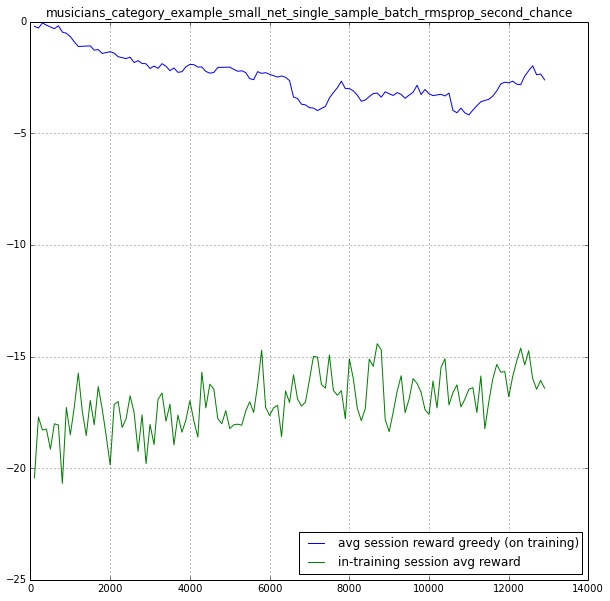

epoch 13000,loss 143.41443, greed 0.40605, rewards: ( train -14.14146, det_train -2.60327) 
rec 143.383 reg 0.032
epoch 13100,loss 84.39261, greed 0.40744, rewards: ( train -15.51865, det_train -2.64294) 
rec 84.361 reg 0.032
epoch 13200,loss 156.54221, greed 0.40882, rewards: ( train -14.62224, det_train -2.97865) 
rec 156.511 reg 0.031
epoch 13300,loss 127.26866, greed 0.41020, rewards: ( train -15.59897, det_train -2.88078) 
rec 127.237 reg 0.031
epoch 13400,loss 168.01186, greed 0.41158, rewards: ( train -13.70947, det_train -2.79270) 
rec 167.980 reg 0.031
epoch 13500,loss 418.20059, greed 0.41296, rewards: ( train -15.83891, det_train -2.61343) 
rec 418.169 reg 0.031
epoch 13600,loss 76.72156, greed 0.41433, rewards: ( train -15.02183, det_train -2.65209) 
rec 76.690 reg 0.031
epoch 13700,loss 106.05251, greed 0.41570, rewards: ( train -16.11792, det_train -2.78688) 
rec 106.022 reg 0.031
epoch 13800,loss 114.53773, greed 0.41707, rewards: ( train -15.95823, det_train -2.90819) 


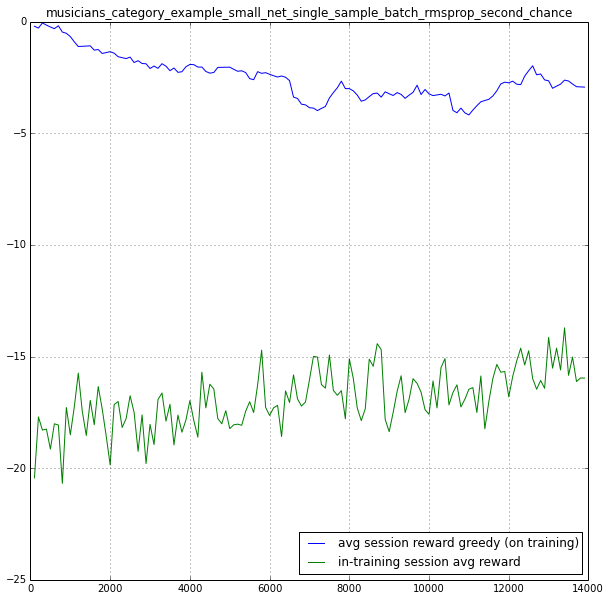

epoch 14000,loss 157.17674, greed 0.41979, rewards: ( train -15.63701, det_train -2.92564) 
rec 157.146 reg 0.030
epoch 14100,loss 88.69671, greed 0.42115, rewards: ( train -16.28193, det_train -2.83307) 
rec 88.667 reg 0.030
epoch 14200,loss 116.64771, greed 0.42251, rewards: ( train -15.05995, det_train -2.74977) 
rec 116.618 reg 0.030
epoch 14300,loss 114.00712, greed 0.42386, rewards: ( train -14.68065, det_train -2.67479) 
rec 113.977 reg 0.030
epoch 14400,loss 79.07761, greed 0.42521, rewards: ( train -14.34219, det_train -2.70731) 
rec 79.048 reg 0.030
epoch 14500,loss 126.11758, greed 0.42656, rewards: ( train -14.81573, det_train -2.73658) 
rec 126.088 reg 0.029
epoch 14600,loss 94.05656, greed 0.42791, rewards: ( train -14.29719, det_train -2.66292) 
rec 94.027 reg 0.029
epoch 14700,loss 83.83391, greed 0.42925, rewards: ( train -15.85882, det_train -2.29663) 
rec 83.805 reg 0.029
epoch 14800,loss 114.60655, greed 0.43059, rewards: ( train -15.33027, det_train -2.26697) 
rec 

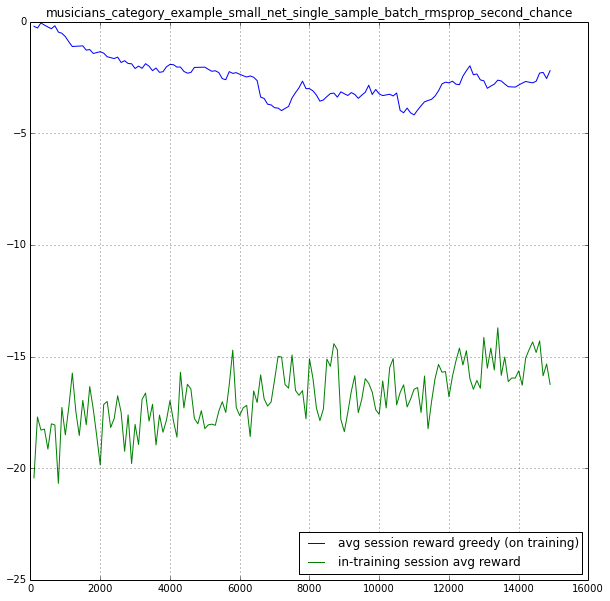

snapshot saved
epoch 15000,loss 122.81213, greed 0.43326, rewards: ( train -15.61195, det_train -2.18624) 
rec 122.784 reg 0.028
epoch 15100,loss 154.24203, greed 0.43460, rewards: ( train -12.69862, det_train -1.86762) 
rec 154.214 reg 0.028
epoch 15200,loss 202.88702, greed 0.43593, rewards: ( train -15.66490, det_train -1.88086) 
rec 202.859 reg 0.028
epoch 15300,loss 165.09775, greed 0.43725, rewards: ( train -14.11550, det_train -1.69277) 
rec 165.070 reg 0.028
epoch 15400,loss 90.45320, greed 0.43858, rewards: ( train -14.65873, det_train -1.92349) 
rec 90.425 reg 0.028
epoch 15500,loss 118.68923, greed 0.43990, rewards: ( train -14.55472, det_train -2.03114) 
rec 118.661 reg 0.028
epoch 15600,loss 90.16240, greed 0.44122, rewards: ( train -15.80886, det_train -2.22803) 
rec 90.135 reg 0.028
epoch 15700,loss 100.05243, greed 0.44253, rewards: ( train -14.54154, det_train -2.50523) 
rec 100.025 reg 0.028
epoch 15800,loss 106.03201, greed 0.44385, rewards: ( train -15.04117, det_tr

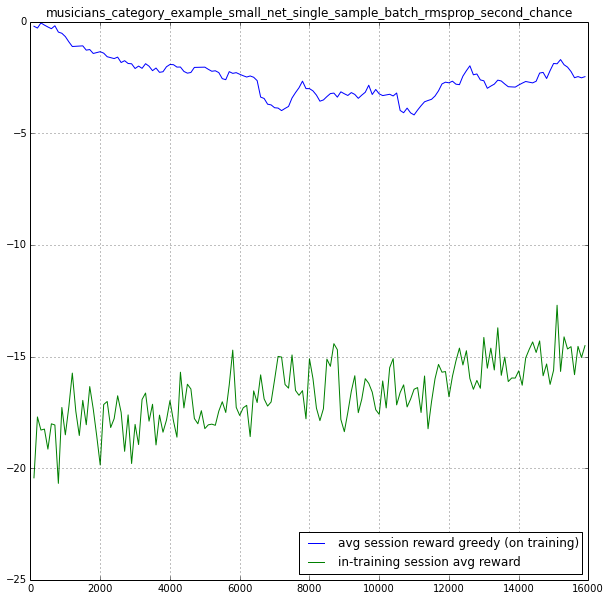

epoch 16000,loss 84.42052, greed 0.44647, rewards: ( train -14.09049, det_train -2.45831) 
rec 84.393 reg 0.027
epoch 16100,loss 84.11086, greed 0.44777, rewards: ( train -14.28572, det_train -2.41248) 
rec 84.084 reg 0.027
epoch 16200,loss 81.27828, greed 0.44907, rewards: ( train -13.21057, det_train -2.47123) 
rec 81.251 reg 0.027
epoch 16300,loss 76.54979, greed 0.45038, rewards: ( train -14.64437, det_train -2.32411) 
rec 76.523 reg 0.027
epoch 16400,loss 89.34228, greed 0.45167, rewards: ( train -15.28322, det_train -2.59170) 
rec 89.316 reg 0.026
epoch 16500,loss 60.20189, greed 0.45297, rewards: ( train -14.69091, det_train -2.53253) 
rec 60.176 reg 0.026
epoch 16600,loss 102.84289, greed 0.45426, rewards: ( train -14.10996, det_train -2.77927) 
rec 102.817 reg 0.026
epoch 16700,loss 19.44103, greed 0.45555, rewards: ( train -15.26405, det_train -2.70135) 
rec 19.415 reg 0.026
epoch 16800,loss 148.57770, greed 0.45684, rewards: ( train -12.28962, det_train -2.73121) 

In [ ]:
n_epochs = 150000
batch_size=1
for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/50000.)*0.9),0.95)
    creeping_epsilon = 1.-creeping_greed
    
    
    #train
    load_random_batch(env,train_attrs,train_cats,batch_size=batch_size)
    
    loss,q_loss,reg_loss,avg_reward = train_fun()
    
    
    
    #reward loss moving average
    ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "Evaluation:"
        print '\ndeterministic'
        set_shared(resolver.epsilon,0)
        print_session(1)
        
        
        
        print '\ncurrent_greediness (%f)'%creeping_greed
        set_shared(resolver.epsilon,creeping_epsilon)
        print_session(1)
        
        plot_scores(experiment_setup_name)

    if epoch_counter% 5000 ==0:
        save(resolver,"/root/agentnet_snapshots/{}.epoch{}.pcl".format(experiment_setup_name,epoch_counter))
        print "snapshot saved"
        
        


    if epoch_counter%100 ==0:
        print "epoch %i,loss %.5f, greed %.5f, rewards: ( train %.5f, det_train %.5f) "%(
            epoch_counter,loss,creeping_greed,ma_reward,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,reg_loss)
        
        score_log["in-training session avg reward"][epoch_counter] = ma_reward
        
        
        
        #greedy train
        set_shared(resolver.epsilon,0)
        avg_reward_greedy = loss_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["avg session reward greedy (on training)"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        set_shared(resolver.epsilon,creeping_epsilon)


        
        
    epoch_counter  +=1


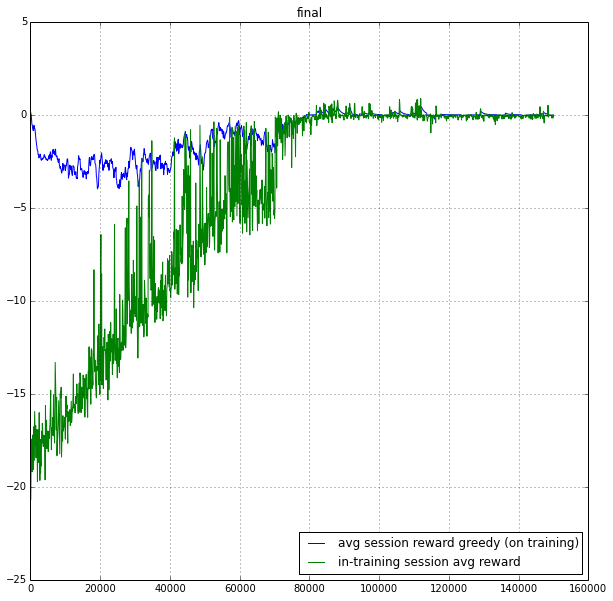

In [34]:
#first chance
plot_scores("final")

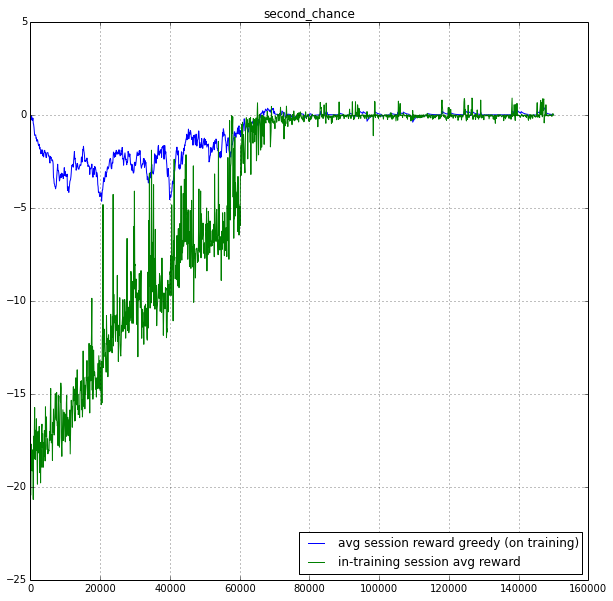

In [32]:
#second chance
plot_scores("second_chance")

In [33]:
load_random_batch(env,train_attrs,train_cats,10)
print_session(10)

#174: first_activity:1965 (-0.694) -> -1.0 | #393: <end_session_action> (-0.032) -> 0.0 | <end>
true:

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:List_of_all-female_bands category:List_of_bass_guitarists

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true:

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:List_of_flautists

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:List_of_individual_K-pop_artists

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:List_of_lead_guitarists category:List_of_guitarists

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:List_of_girl_groups category:List_of_J-pop_artists

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:List_of_girl_groups category:List_of_lead_vocalists

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:List_of_performers_on_Top_of_the_Pops

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:Li

#393: <end_session_action> (-0.051) -> 0.0 | <end>
true:


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


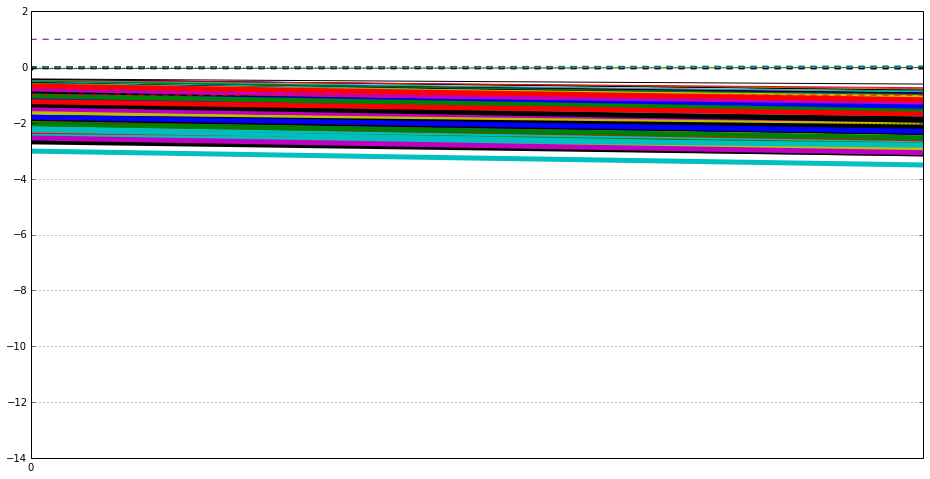


#393: <end_session_action> (-0.051) -> 0.0 | <end>
true: category:List_of_all-female_bands category:List_of_bass_guitarists


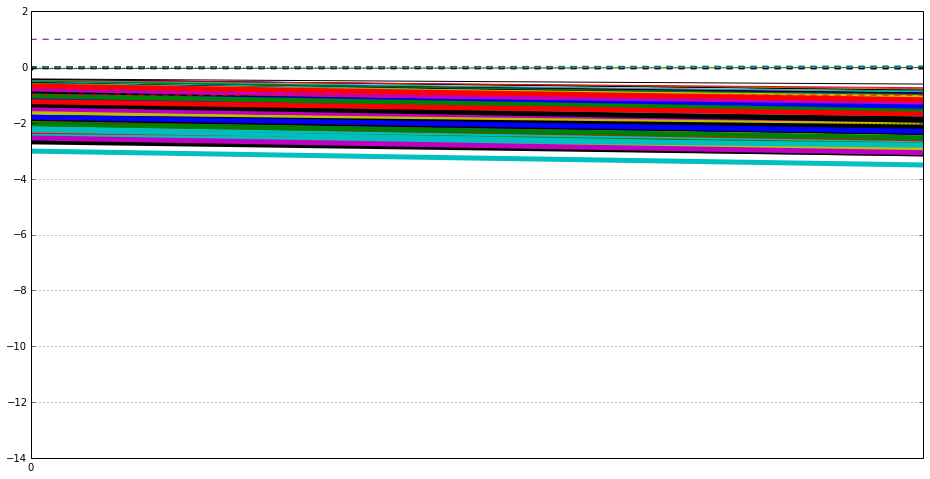


#393: <end_session_action> (-0.051) -> 0.0 | <end>
true:


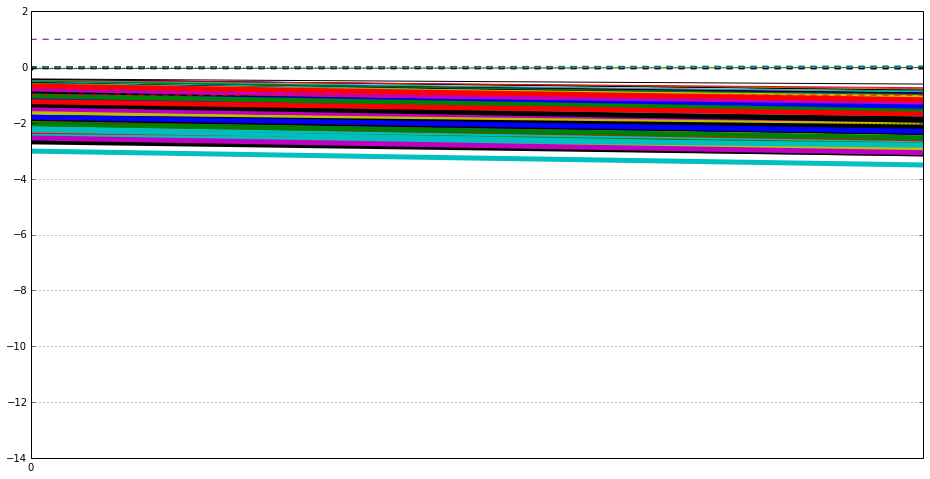

In [34]:
print_session(display=True,legend=False)

#115: Occupation:guitarist (-0.996) -> -1.0 | #2: Cause of death:is_known (-1.509) -> 1.0 | #267: Occupation:saxophonist (-2.264) -> -1.0 | #266: Alma mater:is_known (-2.266) -> -1.0 | #171: first_activity:1968 (-2.306) -> -1.0 | #120: Occupation:bassist (-3.553) -> -1.0 | #345: category:List_of_noise_musicians (-4.315) -> -2.0 | #76: Occupation:teacher (-2.477) -> -1.0 | #89: Occupation:comedian (-2.296) -> 1.0 | #67: Genres:coast (-2.952) -> -1.0 | #207: Occupation:arranger (-4.245) -> -1.0 | #247: Website:is_known (-7.182) -> -1.0 | #250: Native name:is_known (-3.992) -> -1.0 | #308: category:List_of_band_name_etymologies (-5.360) -> -2.0 | #298: Genres:wave (-4.273) -> -1.0 | #254: Genres:big (-6.076) -> -1.0 | #182: Origin:england (-5.467) -> -1.0 | #195: Origin:california (-4.961) -> -1.0 | #188: Partner(s):is_known (-5.989) -> -1.0 | #314: category:List_of_smooth_jazz_musicians (-6.380) -> -2.0 | <end>
true:


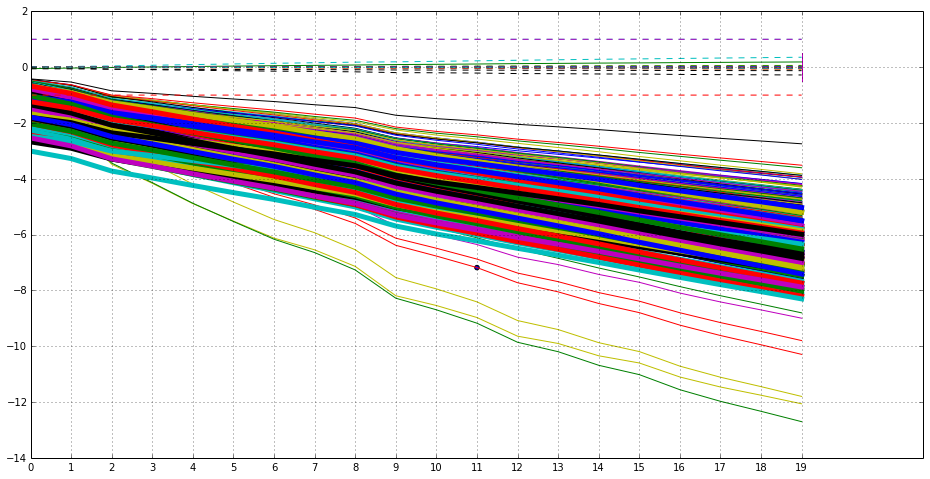


#8: Occupation:record (-1.368) -> -1.0 | #14: Genres:urban (-0.901) -> -1.0 | #76: Occupation:teacher (-0.982) -> -1.0 | #86: Genres:gospel (-1.686) -> -1.0 | #136: Residence:is_known (-2.367) -> -1.0 | #80: Genres:jazz (-1.521) -> -1.0 | #387: category:List_of_musicians_from_Chicago (-2.515) -> -2.0 | #377: category:List_of_alternative_rock_artists (-2.905) -> -2.0 | #154: Genres:folk (-2.015) -> -1.0 | #5: Occupation:personality (-2.784) -> -1.0 | #97: Genres:chicago (-2.572) -> -1.0 | #17: Home town:is_known (-3.420) -> -1.0 | #314: category:List_of_smooth_jazz_musicians (-4.320) -> -2.0 | #274: Genres:nu (-4.097) -> -1.0 | #106: Genres:swing (-3.920) -> -1.0 | #352: category:List_of_reggae_musicians (-5.698) -> -2.0 | #382: category:List_of_Canadian_musicians (-5.786) -> -2.0 | #112: Origin:texas (-4.689) -> -1.0 | #38: Instruments:saxophone (-4.418) -> -1.0 | #74: Genres:j-pop (-4.069) -> -1.0 | <end>
true: category:List_of_all-female_bands category:List_of_bass_guitarists


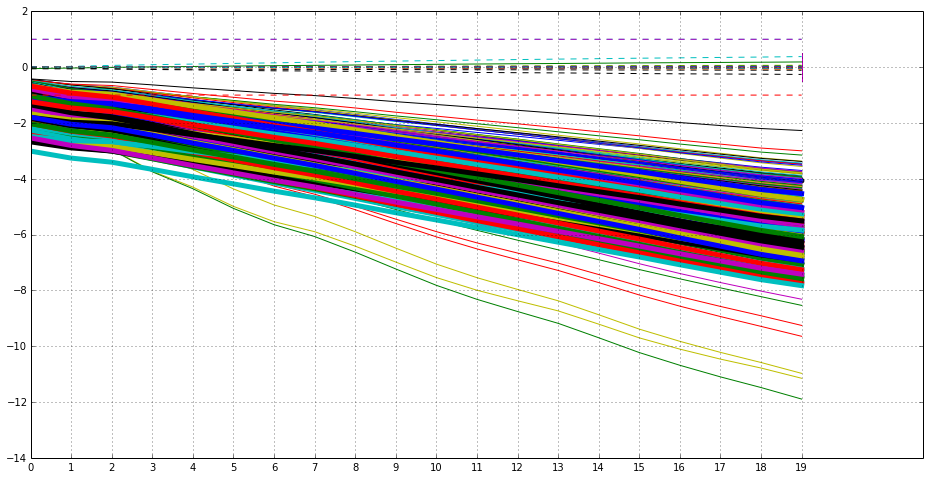


#272: Occupation:artist (-0.818) -> -1.0 | #150: Genres:acoustic (-1.178) -> -1.0 | #337: category:List_of_tenors_in_non-classical_music (-3.087) -> -2.0 | #157: Occupation:educator (-1.702) -> -1.0 | #391: category:List_of_saxophonists (-2.518) -> -2.0 | #41: Instruments:flute (-1.519) -> -1.0 | #217: Genres:world (-2.821) -> -1.0 | #46: Occupation:tv (-2.670) -> -1.0 | #77: Genres:soul (-2.139) -> -1.0 | #42: Instruments:trombone (-2.649) -> -1.0 | #83: Genres:trip (-3.354) -> -1.0 | #175: Origin:germany (-3.929) -> -1.0 | #333: category:List_of_Christian_hip_hop_and_rap_artists (-4.741) -> -2.0 | #197: Nationality:is_known (-4.484) -> -1.0 | #185: Known for:is_known (-3.716) -> -1.0 | #167: Genres:rock (-4.538) -> 1.0 | #289: decades_active:1940 (-4.698) -> -1.0 | #81: Genres:death (-5.647) -> -1.0 | #111: Agent:is_known (-4.002) -> -1.0 | #111: Agent:is_known (-4.171) -> 0.0 | <end>
true:


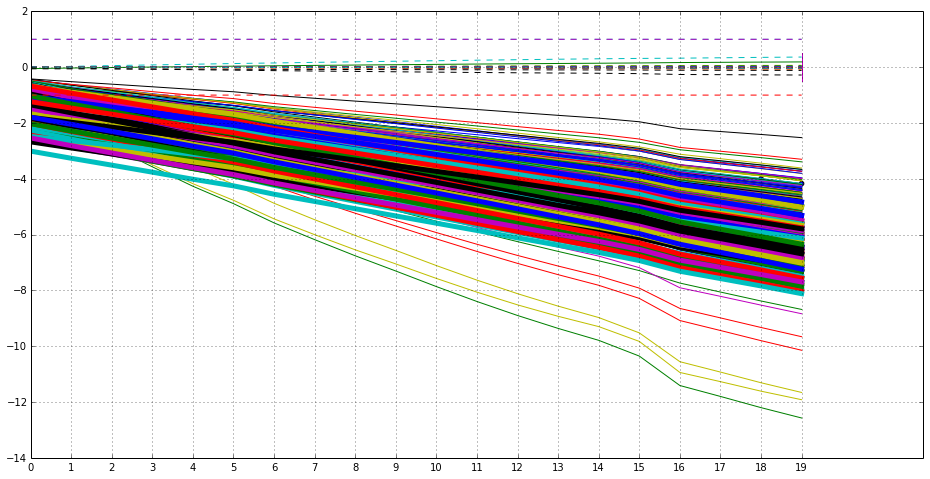

In [35]:
#pure "random" case
set_shared(epsilon,1.0)
print_session(display=True,legend=False)